# <center> Reproducible and Shareable Quantifications of Pathogenicity </center>
<center>Manrai, Wang, Patel, Kohane.
*Pacific Symposium on Biocomputing 2016* Submission</center>

### 1. Loading and Cleaning Pathogenicity Assertions for all Diseases from ClinVar

The ClinVar database [http://www.ncbi.nlm.nih.gov/clinvar/] contains pathogenicity assertions for genetic variants across a broad set of diseases. First, let's use the ANNOVAR tool [http://annovar.openbioinformatics.org/en/latest/] to download these annotations locally. After running the following command, a new directory called "humandb" will be created to store the ClinVar annotations, and temporary files will be removed. Exit code 0 indicates success.

In [1]:
import os
os.system('annotate_variation.pl -buildver hg19 -downdb -webfrom annovar clinvar_20150629 humandb/')

0

Let's look at a few lines of this file:

In [2]:
with open('humandb/hg19_clinvar_20150629.txt') as infile:
    first_five_lines = [next(infile) for i in range(5)]
print first_five_lines

['1\t883516\t883516\tG\tA\tCLINSIG=untested;CLNDBN=Malignant_melanoma;CLNREVSTAT=no_assertion_provided;CLNACC=RCV000064926.2;CLNDSDB=MedGen:SNOMED_CT;CLNDSDBID=C0025202:2092003\n', '1\t891344\t891344\tG\tA\tCLINSIG=untested;CLNDBN=Malignant_melanoma;CLNREVSTAT=no_assertion_provided;CLNACC=RCV000064927.2;CLNDSDB=MedGen:SNOMED_CT;CLNDSDBID=C0025202:2092003\n', '1\t891344\t891344\tG\tC\tCLINSIG=untested;CLNDBN=Malignant_melanoma;CLNREVSTAT=no_assertion_provided;CLNACC=RCV000064927.2;CLNDSDB=MedGen:SNOMED_CT;CLNDSDBID=C0025202:2092003\n', '1\t906168\t906168\tG\tA\tCLINSIG=untested;CLNDBN=Malignant_melanoma;CLNREVSTAT=no_assertion_provided;CLNACC=RCV000064940.2;CLNDSDB=MedGen:SNOMED_CT;CLNDSDBID=C0025202:2092003\n', '1\t949523\t949523\tC\tT\tCLINSIG=pathogenic;CLNDBN=Immunodeficiency_38;CLNREVSTAT=no_assertion_criteria_provided;CLNACC=RCV000162196.2;CLNDSDB=MedGen:OMIM;CLNDSDBID=CN221808:616126\n']


We can load this file more cleanly with the pandas library (http://pandas.pydata.org/):

In [3]:
import pandas as pd
raw_clinvar = pd.read_table('humandb/hg19_clinvar_20150629.txt', header=None)
raw_clinvar.columns = ['Chromosome','Start','Stop','Ref','Alt','ClinSig']
print 'There are %s rows in this version of ClinVar.' %raw_clinvar.shape[0]

distinct_variants = set(zip(raw_clinvar.Chromosome,raw_clinvar.Start,raw_clinvar.Stop,raw_clinvar.Ref,raw_clinvar.Alt))
num_distinct_variants = len(distinct_variants)
print 'There are %s distinct variants in this version of ClinVar.' %num_distinct_variants

There are 133015 rows in this version of ClinVar.
There are 132584 distinct variants in this version of ClinVar.


Taking a closer look at raw_clinvar, we see that the clinical significance data is squished together in one field (ClinSig):

In [4]:
raw_clinvar.head(5)

,Chromosome,Start,Stop,Ref,Alt,ClinSig
0,1,883516,883516,G,A,CLINSIG=untested;CLNDBN=Malignant_melanoma;CLN...
1,1,891344,891344,G,A,CLINSIG=untested;CLNDBN=Malignant_melanoma;CLN...
2,1,891344,891344,G,C,CLINSIG=untested;CLNDBN=Malignant_melanoma;CLN...
3,1,906168,906168,G,A,CLINSIG=untested;CLNDBN=Malignant_melanoma;CLN...
4,1,949523,949523,C,T,CLINSIG=pathogenic;CLNDBN=Immunodeficiency_38;...


Separating this field:

In [5]:
assertion = [x.split(';')[0].split('=')[1] for x in raw_clinvar.ClinSig]
disease = [x.split(';')[1].split('=')[1] for x in raw_clinvar.ClinSig]
accession = [x.split(';')[3].split('=')[1] for x in raw_clinvar.ClinSig]
clinvar = raw_clinvar.drop('ClinSig',1)
clinvar['assertion'], clinvar['disease'], clinvar['accession'] = assertion, disease, accession
clinvar.head(25)

,Chromosome,Start,Stop,Ref,Alt,assertion,disease,accession
0,1,883516,883516,G,A,untested,Malignant_melanoma,RCV000064926.2
1,1,891344,891344,G,A,untested,Malignant_melanoma,RCV000064927.2
2,1,891344,891344,G,C,untested,Malignant_melanoma,RCV000064927.2
3,1,906168,906168,G,A,untested,Malignant_melanoma,RCV000064940.2
4,1,949523,949523,C,T,pathogenic,Immunodeficiency_38,RCV000162196.2
5,1,949696,949696,-,G,pathogenic,Immunodeficiency_38,RCV000148989.4
6,1,949739,949739,G,T,pathogenic,Immunodeficiency_38,RCV000148988.4
7,1,955597,955597,G,T,probable-non-pathogenic,not_specified,RCV000116272.2
8,1,957640,957640,C,T,probable-non-pathogenic,not_specified,RCV000116258.2
9,1,976629,976629,C,T,non-pathogenic,not_specified,RCV000116282.1


Notice that some of variants contain multiple assertions, separated by the ',' or '|' characters. We can extract just these rows as follows:

In [6]:
import re

accession = clinvar.accession.map(lambda x: re.split(r'[,|]+',x) if ('|' in x or ',' in x) else [x])
multi_rows = [i for i, e in enumerate(accession) if len(e) > 1]
multi = clinvar.ix[multi_rows,:]
multi.head(5)

,Chromosome,Start,Stop,Ref,Alt,assertion,disease,accession
22,1,982844,982844,G,C,probable-non-pathogenic|probable-pathogenic,not_specified|not_provided,RCV000116263.2|RCV000171145.1
81,1,1959699,1959699,G,A,other|other|other,Generalized_epilepsy_with_febrile_seizures_plu...,RCV000017599.1|RCV000017600.1|RCV000022558.1
85,1,2160305,2160305,G,A,"pathogenic,pathogenic","Shprintzen-Goldberg_syndrome,Shprintzen-Goldbe...","RCV000030819.24,RCV000030820.24"
86,1,2160305,2160305,G,T,"pathogenic,pathogenic","Shprintzen-Goldberg_syndrome,Shprintzen-Goldbe...","RCV000030819.24,RCV000030820.24"
87,1,2160306,2160306,G,A,"pathogenic,pathogenic","Shprintzen-Goldberg_syndrome,Shprintzen-Goldbe...","RCV000030818.24,RCV000033005.24"


We can flatten the clinvar data so there is one <b>assertion</b> per line:

In [7]:
assertion = clinvar.assertion.map(lambda x: re.split(r'[,|]+',x) if ('|' in x or ',' in x) else [x])
disease = clinvar.disease.map(lambda x: re.split(r'[,|]+',x) if ('|' in x or ',' in x) else [x])
accession = clinvar.accession.map(lambda x: re.split(r'[,|]+',x) if ('|' in x or ',' in x) else [x])
v0 = clinvar.Chromosome.tolist()
v1 = clinvar.Start.tolist()
v2 = clinvar.Stop.tolist()
v3 = clinvar.Ref.tolist()
v4 = clinvar.Alt.tolist()
variants = zip(v0,v1,v2,v3,v4)
flat = []
for i, v in enumerate(variants):
    num_assertions = len(accession[i])
    v = list(v)
    if num_assertions > 1:  
        flat += [v+[assertion[i][j],disease[i][j],accession[i][j]] for j in range(num_assertions)]
    else:
        flat += [v+assertion[i]+disease[i]+accession[i]]
flat_clinvar = pd.DataFrame(flat)
flat_clinvar.columns = ['Chromosome','Start','Stop','Ref','Alt','Assertion','Disease','Accession']
flat_clinvar.head(5)

,Chromosome,Start,Stop,Ref,Alt,Assertion,Disease,Accession
0,1,883516,883516,G,A,untested,Malignant_melanoma,RCV000064926.2
1,1,891344,891344,G,A,untested,Malignant_melanoma,RCV000064927.2
2,1,891344,891344,G,C,untested,Malignant_melanoma,RCV000064927.2
3,1,906168,906168,G,A,untested,Malignant_melanoma,RCV000064940.2
4,1,949523,949523,C,T,pathogenic,Immunodeficiency_38,RCV000162196.2


Let's deduplicate:

In [8]:
flat_clinvar = flat_clinvar.drop_duplicates()
print "There are %s distinct assertions in this version of Clinvar." %flat_clinvar.shape[0]

There are 160487 distinct assertions in this version of Clinvar.


and output to file:

In [9]:
flat_clinvar.to_csv(path_or_buf='flat_clinvar.tsv',sep='\t',index=False,
                   columns=['Chromosome','Start','Stop','Ref','Alt','Assertion',
                               'Disease','Accession'])

To reduce to Pathogenic SNPs, we can simply run:

In [10]:
pathogenic_SNPs = flat_clinvar[(flat_clinvar.Start == flat_clinvar.Stop) & (flat_clinvar.Assertion == 'pathogenic') &
                              (flat_clinvar.Alt.str.len() == 1) & (flat_clinvar.Ref.str.len() == 1)]
print 'There are %s pathogenic SNP assertions in this version of ClinVar.' % pathogenic_SNPs.shape[0]

There are 34173 pathogenic SNP assertions in this version of ClinVar.


Let's output these to file:

In [11]:
pathogenic_SNPs.to_csv(path_or_buf='flat_clinvar_pathogenic_SNPs.tsv',sep='\t',index=False,
                       columns=['Chromosome','Start','Stop','Ref','Alt','Assertion',
                               'Disease','Accession'])

### 2a. Pulling Allele Frequency Data

#### 2a.1. NHLBI ESP

We first retrieve frequency data from the NHLBI ESP [http://evs.gs.washington.edu/EVS/]:

In [12]:
os.system('annotate_variation.pl -downdb -webfrom annovar -build hg19 esp6500si_ea humandb/')
os.system('annotate_variation.pl -downdb -webfrom annovar -build hg19 esp6500si_aa humandb/')
os.system('annotate_variation.pl -downdb -webfrom annovar -build hg19 esp6500si_all humandb/')

0

We can use these data to filter clinical variants:

In [13]:
infile_name = 'flat_clinvar_pathogenic_SNPs.tsv'
outfile_name = 'ESP'
os.system('annotate_variation.pl -filter -dbtype esp6500si_all -build hg19 -out %s %s humandb/' % (outfile_name,infile_name))

0

In [14]:
ESP_data = pd.read_table('ESP.hg19_esp6500si_all_dropped',
                     header=None)
ESP_data = ESP_data.drop(0,1)
ESP_data.columns = ['ESP_Overall_Frequency','Chromosome','Start','Stop','Ref','Alt',
                'Assertion','Disease','Accession']
print "There are %s variant-disease assertions with ESP frequency data available." %ESP_data.shape[0]
ESP_data.head(5)

There are 3403 variant-disease assertions with ESP frequency data available.


,ESP_Overall_Frequency,Chromosome,Start,Stop,Ref,Alt,Assertion,Disease,Accession
0,0.000154,1,100381954,100381954,A,G,pathogenic,Glycogen_storage_disease_IIIb,RCV000001157.2
1,0.000154,1,100381954,100381954,A,G,pathogenic,Glycogen_storage_disease_IIIa,RCV000001158.2
2,0.000154,1,10042538,10042538,C,T,pathogenic,Leber_congenital_amaurosis_9,RCV000030764.1
3,0.000077,1,10042629,10042629,G,T,pathogenic,Leber_congenital_amaurosis_9,RCV000030769.2
4,0.001076,1,10042688,10042688,G,A,pathogenic,Leber_congenital_amaurosis_9,RCV000030765.2


#### 2a.2. Broad ExAc
Now we retrieve frequency data from the Broad ExAc [http://exac.broadinstitute.org]:

In [15]:
os.system('annotate_variation.pl -downdb -webfrom annovar -build hg19 exac03 humandb/')

0

In [16]:
infile_name = 'flat_clinvar_pathogenic_SNPs.tsv'
outfile_name = 'ExAc'
os.system('annotate_variation.pl -filter -build hg19 -dbtype exac03 -out %s %s humandb/' % (outfile_name,infile_name))

0

In [17]:
ExAc_data = pd.read_table('ExAc.hg19_exac03_dropped',
                     header=None)
ExAc_data = ExAc_data.drop(0,1)
ExAc_data.columns = ['ExAc_Overall_Frequency','Chromosome','Start','Stop','Ref','Alt',
                'Assertion','Disease','Accession']
print "There are %s variant-disease assertions with ExAc frequency data available." %ExAc_data.shape[0]
ExAc_data.head(5)

There are 10096 variant-disease assertions with ExAc frequency data available.


,ExAc_Overall_Frequency,Chromosome,Start,Stop,Ref,Alt,Assertion,Disease,Accession
0,0.000008,1,100316614,100316614,C,T,pathogenic,Glycogen_storage_disease_IIIb,RCV000001153.2
1,0.000008,1,100316614,100316614,C,T,pathogenic,Glycogen_storage_disease_type_III,RCV000020373.1
2,0.000017,1,100340950,100340950,C,T,pathogenic,Glycogen_storage_disease_IIIa,RCV000001165.2
3,0.000017,1,100340950,100340950,C,T,pathogenic,Glycogen_storage_disease_type_III,RCV000020372.1
4,0.000016,1,100345603,100345603,G,T,pathogenic,Glycogen_storage_disease_IIIa,RCV000001159.2


####2a.3. Merging

Let's merge the two data structures:

In [18]:
merged = pd.merge(ESP_data,ExAc_data,how='outer',on=['Chromosome','Start','Stop','Ref','Alt','Disease',
                                                     'Assertion','Accession'])
print "There are %s variant-disease assertions with frequency data in either ExAC or ESP." %merged.shape[0]

num_SNPs = merged.shape[0]
print "There are %s SNP variant-disease assertions with frequency data in either ExAc or ESP." %num_SNPs

num_variants = len(set(zip(merged.Chromosome,merged.Start,merged.Stop,merged.Ref,merged.Alt)))
print "There are %s distinct variants in the set of variant-disease assertions with frequency data in either ExAc or ESP." %num_variants

num_diseases = len(set(zip(merged.Disease)))
print "There are %s distinct diseases in the set of variant-disease assertions with frequency data in either ExAc or ESP." %num_diseases

There are 10287 variant-disease assertions with frequency data in either ExAC or ESP.
There are 10287 SNP variant-disease assertions with frequency data in either ExAc or ESP.
There are 8441 distinct variants in the set of variant-disease assertions with frequency data in either ExAc or ESP.
There are 2858 distinct diseases in the set of variant-disease assertions with frequency data in either ExAc or ESP.


In [19]:
merged.to_csv(path_or_buf='merged_output.csv',sep=',',index=False,
                   columns=['Chromosome','Start','Stop','Ref','Alt','Assertion',
                            'Disease','Accession','ExAc_Overall_Frequency','ESP_Overall_Frequency'])

### 2b. Pulling Pubmed Publications

The following function, using the Python module BeautifulSoup, retrieves PubMed IDs directly from the ClinVar website:

In [20]:
from bs4 import BeautifulSoup
import urllib2

def getPubMedIDs(RCV):
    try:
        response = urllib2.urlopen("http://www.ncbi.nlm.nih.gov/clinvar/" + RCV)
    except urllib2.HTTPError:
        print "Page not found"
    else:
        soup = BeautifulSoup(response.read())
        tag = soup.body.find("div", id="clinvar_rec_pubmed_ids1")
        if tag:
            return tag.text.split(", ")
    return []

Let's test this function on a few examples:

In [21]:
print "Expecting 5 PubMedIDs for RCV000019428:", getPubMedIDs("RCV000019428")
print "Expecting 2 PubMedIDs for RCV000019429:", getPubMedIDs("RCV000019429")
print "Expecting 0 PubMedIDs for RCV000116253.2:", getPubMedIDs("RCV000116253.2")

Expecting 5 PubMedIDs for RCV000019428: [u'6289314', u'2992507', u'3243553', u'9649566', u'16143024']
Expecting 2 PubMedIDs for RCV000019429: [u'2851587', u'7586659']
Expecting 0 PubMedIDs for RCV000116253.2: []


### 3. Penetrance

We are interested in the quantitative disease risk associated with pathogenic variation. We define the <i>penetrance</i> of genotype $G=j$ for disease $D$ as:

\begin{eqnarray}
\text{Penetrance} = P(D|G=j) = \frac{k \times P(G=j|D)}{P(G=j)} \\
= \frac{k \times P(G=j|D)}{P(G=j|D)\times k + P(G=j|\overline{D})\times (1-k)}
\end{eqnarray}

where $k$ is the prevalence of the disease, $D$ signifies affected and $\overline{D}$ signifies unaffected.

### 4. Summarizing the Data

#### 4.1 Diseasome-wide analyses with ClinVar variants

First, let's create a directory to store plots:

In [22]:
import os
os.system('mkdir plots')

0

In [23]:
a = flat_clinvar.groupby(['Chromosome','Start','Stop','Ref','Alt'])

var_counts = list(a.size().values)
assertions_per_variant = [var_counts.count(i) for i in range(1,20)]

132584

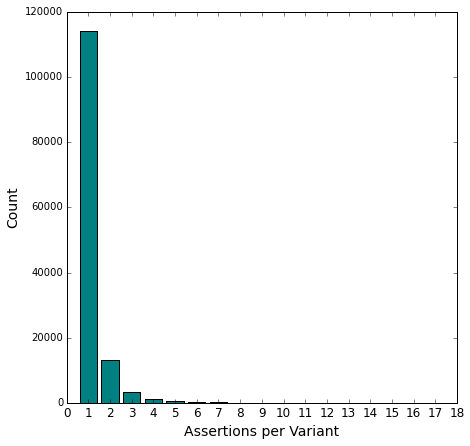

In [24]:
%matplotlib inline

import matplotlib
import matplotlib.pyplot as plt

plt.figure(figsize = (7,7))
plt.bar(range(1,len(assertions_per_variant)+1),assertions_per_variant,
        align='center',color='teal')
plt.xlabel('Assertions per Variant',fontsize=14)
plt.ylabel('Count',fontsize=14)
#plt.title('Pathogenicity Assertions per Variant in ClinVar')
plt.xlim([0,15])
plt.xticks(range(len(assertions_per_variant)),fontsize=12)
plt.savefig('plots/assertions_per_variant.pdf')

assertions_per_variant[0]/(len(a.groups))
len(a.groups)

#### 4.2 Uncertainty in the disease risk conveyed by pathogenic variation

Here we perform a sensitivity analysis for penetrance using the disease hypertrophic cardiomyopathy (HCM). Making our assumptions explicit:

<ul>
<li>The prevalence of HCM is $1/500$ [Maron et al., <i>Circulation</i> 1995]</li>
<li>There are more than a thousand causal variants for HCM [Maron et al., <i>J Am. Coll. Cardiol.</i>, 2012]. A conservative estimate for $h$, the heterogeneity parameter, is therefore $h=0.1$. A more realistic estimate is $h=0.001$</li>
<li>HCM is autosomal dominant: a single copy of a highly-penetrant causal allele is sufficient to cause disease</li>
</ul>

In [25]:
# parameters above as Python variables
import numpy as np

prev = 1.0/500
het_range = np.linspace((0.001),(0.1),10)
pen = {} # to be computed below
genetic_model = 'AD'

Recall:
    
\begin{eqnarray}
\text{Penetrance} = P(D|G=j) = \frac{k \times P(G=j|D)}{P(G=j)} \\
= \frac{k \times P(G=j|D)}{P(G=j|D)\times k + P(G=j|\overline{D})\times (1-k)}
\end{eqnarray}

Thus, grabbing all HCM variants and computing penetrance can be accomplished by:

In [26]:
HCM = merged[merged.Disease.str.contains('hypertrophic_cardiomyopathy')]
HCM = HCM.drop_duplicates(subset = ['Chromosome','Start','Stop','Ref','Alt']) # 81 distinct variants
raw_names = zip(HCM.Chromosome,HCM.Start,HCM.Ref,HCM.Alt)
clean_names = [str(chrom)+':'+str(int(pos))+str(ref)+'>'+alt for (chrom,pos,ref,alt) in raw_names]
HCM[['Chromosome','Start','Ref','Alt','ExAc_Overall_Frequency','ESP_Overall_Frequency','Accession','Disease']].head(5)

,Chromosome,Start,Ref,Alt,ExAc_Overall_Frequency,ESP_Overall_Frequency,Accession,Disease
199,1,201328373,G,A,0.0004,0.000461,RCV000013222.22,Familial_hypertrophic_cardiomyopathy_2
203,1,201337340,G,A,0.0005,0.000308,RCV000149450.1,Primary_familial_hypertrophic_cardiomyopathy
250,1,236911044,C,T,0.0002,0.000077,RCV000169901.2,Familial_hypertrophic_cardiomyopathy_23
448,10,69881254,A,G,0.0009,0.000923,RCV000043545.1,Familial_hypertrophic_cardiomyopathy_22
451,10,69959174,C,T,0.0030,0.002076,RCV000043542.1,Familial_hypertrophic_cardiomyopathy_22


In [27]:
import numpy as np

max_freqs = [np.nanmax(np.array([x,y])) for (x,y) in zip(HCM.ESP_Overall_Frequency,HCM.ExAc_Overall_Frequency)]
max_freqs = [x**2 + 2*x*(1-x) for x in max_freqs]

for i,var in enumerate(clean_names):
    these_pens = []
    for h in het_range:
        f = max_freqs[i]
        these_pens += [min(prev*h/f,1)]
    pen[var] = these_pens

In [28]:
# now export to R
import csv
outfile = open('sens_analysis','w')
for k,v in pen.items():
    outfile.write(k)
    for i in v:
        outfile.write(','+str(i))
    outfile.write('\n')
outfile.close()

Let's retrieve all PubMed IDs for these accessions:

In [29]:
HCM_PMIDs = {}
for acc in set(HCM.Accession):
    HCM_PMIDs[acc] = getPubMedIDs(acc)
HCM_PMIDs

{'RCV000007249.5': [u'10820940', u'11586962', u'10355918', u'11827995'],
 'RCV000009135.2': [],
 'RCV000009147.3': [u'7786104', u'10424815'],
 'RCV000009149.3': [],
 'RCV000009150.3': [],
 'RCV000009326.2': [],
 'RCV000012981.21': [u'11815424', u'16236538', u'16949038'],
 'RCV000012982.15': [],
 'RCV000013222.22': [u'7898523', u'2946667', u'10405326'],
 'RCV000013231.23': [u'9241277', u'11801593', u'18430738'],
 'RCV000013233.22': [u'11815426', u'18175163'],
 'RCV000013234.21': [],
 'RCV000013258.23': [],
 'RCV000013484.23': [],
 'RCV000015106.20': [],
 'RCV000015108.24': [],
 'RCV000015111.25': [u'9535554', u'12404107'],
 'RCV000015167.24': [],
 'RCV000015176.24': [u'7786104', u'10424815'],
 'RCV000015186.24': [u'16267253', u'12749056', u'18506004'],
 'RCV000015210.20': [],
 'RCV000015212.24': [],
 'RCV000019991.26': [],
 'RCV000019996.28': [u'10966831', u'17611253', u'16267253', u'18506004'],
 'RCV000022712.24': [u'12639993', u'17655857', u'21167350'],
 'RCV000023054.2': [],
 'RCV000